# Условие

После внедрения улучшений в процесс доставки еды необходимо провести анализ, сравнив контрольную и тестовую группы пользователей.

Предоставлен набор данных, содержащий следующие параметры:
- идентификатор заказа,
- время доставки,
- район доставки,
- принадлежность к контрольной или тестовой группе.

Цель анализа:
- Определить, целесообразно ли масштабировать внедрённое улучшение на всех пользователей.
- Оценить, привели ли изменения к улучшению показателей в тестовой группе, и являются ли наблюдаемые различия статистически значимыми.

# Решение

Решение будет состоять из нескольких этапов:

1. Понимание данных

    1.1. Загрузка и подготовка данных

    1.2. Нормальность распределения

    1.3. Проверка выбросов и размахов

    1.4. Средние и медианы

2. Проведение теста

    2.1. Определение методологии

    2.2. Формулирование гипотез

    2.3. Проведение теста и его интерпретация

3. Рекомендации

# 1. Понимание данных

## 1.1. Загрузка и подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
# Создадим DataFrame
df = pd.read_csv("data/data.csv")

In [3]:
# Проверим данные фрэйма
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20196 entries, 0 to 20195
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   order_id          20196 non-null  int64 
 1   delivery_time     20196 non-null  int64 
 2   district          20196 non-null  object
 3   experiment_group  20196 non-null  object
dtypes: int64(2), object(2)
memory usage: 631.2+ KB


In [4]:
# Проверим первые 5 строк фрэйма
df.head()

,order_id,delivery_time,district,experiment_group
0,3159,44,Purlieus,control
1,10426,51,Purlieus,control
2,9155,46,Purlieus,control
3,10699,34,Purlieus,control
4,10061,43,Purlieus,control


In [5]:
# Найдем количество строк, содержащих NaN
num_nan_rows = df.isna().any(axis=1).sum()
print(f"Количество строк, содержащих NaN: {num_nan_rows}")

Количество строк, содержащих NaN: 0


In [6]:
# Удалим пропущенные данные, если таковые имеются:
if num_nan_rows > 0:
    df.dropna()

In [7]:
# Проверим, нет ли задвоения данных (одинаковые значения в order_id)
order_id_counts = df['order_id'].value_counts()
duplicate_rows = order_id_counts[order_id_counts > 1].index.tolist()
print(f"Задвоение данны  IDs: {duplicate_rows}")

Задвоение данны  IDs: []


In [8]:
# Удалим задвоенные строки, если таковые имеются
if duplicate_rows:
    df.drop_duplicates(subset=['order_id'], keep='first')

In [9]:
# Найдём уникальные значения в столбце experiment_group
experiment_groups = df["experiment_group"].unique()
experiment_groups

array(['control', 'test'], dtype=object)

In [10]:
# Найдём уникальные значения в столбце district
districts = df["district"].unique()
districts

array(['Purlieus', 'Central', 'Suburb'], dtype=object)

In [11]:
# Создадим цветовую палитру для гистограмм
sns.set_theme(style="whitegrid")
palette = sns.color_palette("viridis", n_colors=2)

## 1.2. Нормальность распределения

In [12]:
# Посчитаем количество строк по экспериментальным группам
df["experiment_group"].value_counts()

experiment_group
test       10104
control    10092
Name: count, dtype: int64

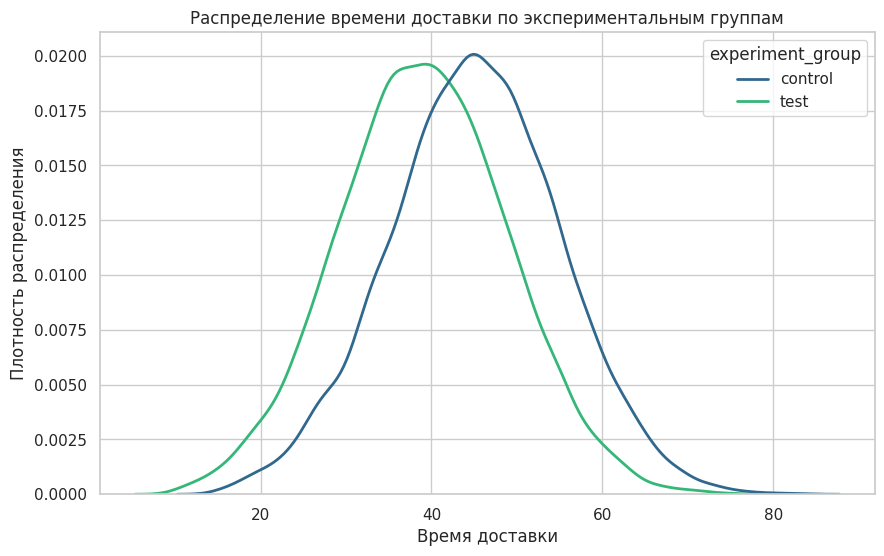

In [13]:
# Построим распределение для каждой экспериментальной группы

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df,
    x="delivery_time",
    hue="experiment_group",
    linewidth=2,
    palette=palette,
)

plt.title("Распределение времени доставки по экспериментальным группам")
plt.xlabel("Время доставки")
plt.ylabel("Плотность распределения")
plt.show()

In [14]:
# Проверим количество данных по каждой из групп и районов

for district in districts:
    print(f"- Район {district} -")
    for group in ["control", "test"]:
        count = len(df[(df["district"] == district) & (df["experiment_group"] == group)])
        print(f"Группа {group}: {count} заказов")
    print()

- Район Purlieus -
Группа control: 8781 заказов
Группа test: 8179 заказов

- Район Central -
Группа control: 669 заказов
Группа test: 1727 заказов

- Район Suburb -
Группа control: 642 заказов
Группа test: 198 заказов



## 1.3. Проверка выбросов и размахов

Проверим подозрительные выбросы, а также определим размахи выборок.

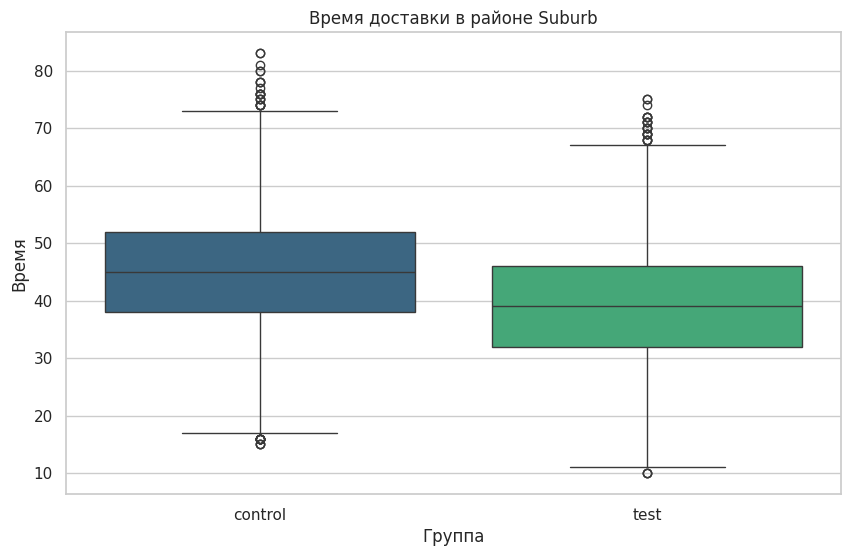

In [15]:
# Построим диаграмму boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x="experiment_group",
    y="delivery_time",
    palette=palette,
    hue="experiment_group",
)
plt.title(f"Время доставки в районе {district}")
plt.xlabel("Группа")
plt.ylabel("Время")
plt.show()

In [16]:
# Посчитаем размахи выборок
for group in ["control", "test"]:
    max_value = df[(df["experiment_group"] == group)]["delivery_time"].max()
    min_value = df[(df["experiment_group"] == group)]["delivery_time"].min()
    print(f"В группе {group} размах: {max_value - min_value}")

В группе control размах: 68
В группе test размах: 65


Выбросы на данных диаграммах не выглядят ошибками ввода данных или аномалиями. Разумным кажется оставить выбросы в этих районах.

## 1.4. Средние и медианы

Посчитаем средние значения.

In [17]:
for group in experiment_groups:
    mean_time = df["delivery_time"][df["experiment_group"] == group].mean()
    print(f"Среднее группы {group}: {mean_time:.2f}")

Среднее группы control: 45.07
Среднее группы test: 39.05


Посчитаем медианные значения.

In [18]:
for group in experiment_groups:
    mean_time = df["delivery_time"][df["experiment_group"] == group].median()
    print(f"Медиана группы {group}: {mean_time:.2f}")

Медиана группы control: 45.00
Медиана группы test: 39.00


Мы наблюдаем незначительную разницу между средними значениями и медианами, что говорит о не слишком значимой роли выбросов.

# 2. Проведение теста

## 2.1. Определение методологии

Исследуемые данные являются количественными. Общая выборка описывается нормальным распределением. Группы являются независимыми. Используем t-критерий Стьюдента.

## 2.2. Формулирование гипотез
Сформулируем гипотезы.

Будем в рамках нулевой гипотезы считать, что разницы между временем доставки до внедрения улучшения и после его внедрения нет. Мы хотели бы найти опровержение этой гипотезы.

$$H_0: \mu_{test} - \mu_{control} = 0$$

Тогда альтернативная гипотеза будет утверждать, что разница во времени доставки есть. В таком случае, мы можем предположить, что улучшение положительно сказывается на времени доставки.

$$H_1: \mu_{test} - \mu_{control} \neq 0$$

Выберем уровень значимости: $\alpha = 0.05$

## 2.3. Проведение теста и его интерпретация

Проведём t-статистику.

In [19]:
control = df["delivery_time"][df["experiment_group"] == "control"]
test = df["delivery_time"][df["experiment_group"] == "test"]

result = stats.ttest_ind(control, test)

result

TtestResult(statistic=np.float64(43.03582663183714), pvalue=np.float64(0.0), df=np.float64(20194.0))

Сравним p-value с уровнем значимости:
- если p-value меньше уровня значимости, принимаем решение, что надо отклонить нулевую гипотезу;
- если p-value больше уровня значимости, оснований отклонить нулевую гипотезу нет.

Мы видим, что p-value = 0.0, то есть p-value < 0.05. Таким образом, мы имеем основания отклонить нулевую гипотезу. Нулевая гипотеза состояла в том, что разницы между временем доставки до внедрения улучшения и после его внедрения нет. Следовательно,
$$\mu_{test} \neq \mu_{control}.$$
Мы можем предположить, что улучшение положительно сказывается на времени доставки.

## 3. Рекомендации.

В тестовых группах результат улучшился: наблюдается уменьшение времени доставки. Результат является статистически значимым.

Внедрять улучшение на всех пользователей рекомендуется. После внедрения ожидается сокращение времени на доставку на 14%.